# Intro
As part of the 2022 Hack the Bubble event hosted by Stacshack, themed "Sci-Fi", I wanted to analyse what factors/features make a good sci-fi movie.

## Goal:
Given information that you would know before a movie is released, can you tell if it will do well? How much money will it make?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import operator

from collections import Counter

In [67]:
credits_df = pd.read_csv('tmdb_5000_credits.csv')
movie_df = pd.read_csv('tmdb_5000_movies.csv')

data = pd.merge(movie_df, credits_df, left_on='id', right_on='movie_id')

In [68]:
data.drop('homepage', axis=1, inplace=True) # useless
data.drop('tagline', axis=1, inplace=True) # useless
data.drop('popularity', axis=1, inplace=True) # would not be known before release
data.drop('keywords', axis=1, inplace=True) # useless
data.drop('title_y', axis=1, inplace=True) # same as title_x
data.drop('original_title', axis=1, inplace=True) # title_x has english titles
data.drop('id', axis=1, inplace=True) # same as movie_id

data = data[data['status'] == 'Released'] # keep only released movies
data.drop('status', axis=1, inplace=True)

In [69]:
data['release_date'] = pd.to_datetime(data['release_date'])
data['year'] = data['release_date'].map(lambda x : x.year)
data['month'] = data['release_date'].map(lambda x : x.month)
data['day'] = data['release_date'].map(lambda x : x.day)

data.drop('release_date', axis=1, inplace=True)

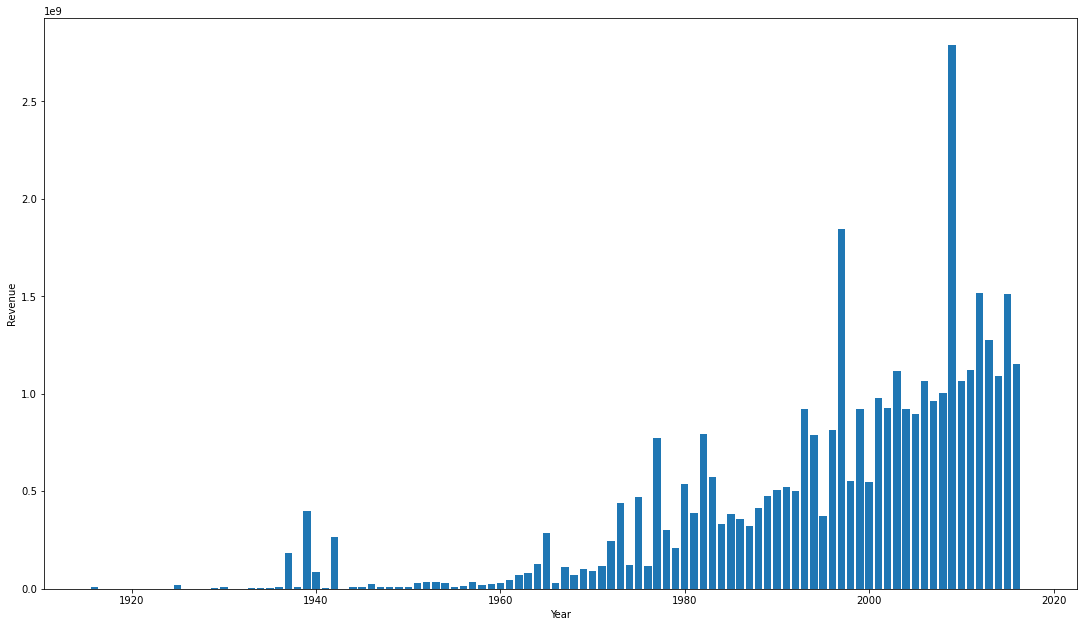

In [70]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.bar(x='year', height='revenue', data=data)
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

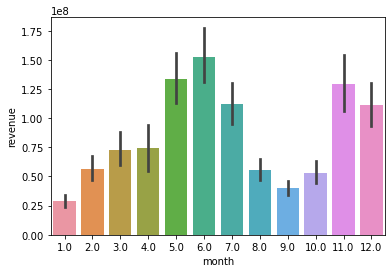

In [71]:
sns.barplot(x='month', y='revenue', data=data)

In [72]:
json_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew']
for col in json_cols:
    data[col] = data[col].apply(json.loads)

In [73]:
data.rename(columns={'title_x':'title'}, inplace=True)

In [74]:
data = data[data['revenue'] > 0]
data = data[data['budget'] > 0]

In [75]:
def isOf(l, name):
    for d in l:
        if d['name'] == name:
            return 1
    return 0

In [76]:
# categorise genres

genres_set = set()
for i in data.index:
    genres = data['genres'][i]
    for x in genres:
        genres_set.add(x['name'])

for genre in genres_set:
    col_name = genre.replace(' ', '_').lower()
    data[col_name] = data['genres'].map(lambda x : isOf(x, genre))
    
# data.drop('genres', axis=1, inplace=True)

In [77]:
# only consider scifi movies
data = data[data['science_fiction'] == 1]
data.drop('science_fiction', axis=1, inplace=True)

In [86]:
# get n most common
def getTopN(column_name, n):
    l = []
    for i in data.index:
        elems = data[column_name][i]
        for x in elems:
            l.append(x['name'])
    
    f = dict(Counter(l))
    f_sorted = sorted(f.items(), key=lambda item : item[1], reverse=True)
    return f_sorted[:n]

In [87]:
data.columns

Index(['budget', 'genres', 'original_language', 'overview',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'spoken_languages', 'title', 'vote_average', 'vote_count', 'movie_id',
       'cast', 'crew', 'year', 'month', 'day', 'war', 'foreign', 'romance',
       'music', 'drama', 'documentary', 'animation', 'family', 'western',
       'comedy', 'adventure', 'horror', 'thriller', 'action', 'fantasy',
       'mystery', 'history', 'crime'],
      dtype='object')

In [108]:
getTopN('production_countries', 10)

[('United States of America', 391),
 ('United Kingdom', 61),
 ('Canada', 34),
 ('Germany', 31),
 ('France', 23),
 ('Australia', 19),
 ('Japan', 12),
 ('Hong Kong', 6),
 ('China', 5),
 ('Czech Republic', 5)]

In [90]:
# categorise production companies

l = [x[0] for x in getTopN('production_companies', 100)]

for prod_comp in l:
    col_name = prod_comp.replace(' ', '_').lower()
    data[col_name] = data['production_companies'].map(lambda x : isOf(x, prod_comp))

In [91]:
# categorise cast

l = [x[0] for x in getTopN('cast', 100)]

for cast in l:
    col_name = 'cast-' + cast.replace(' ', '_').lower()
    data[col_name] = data['cast'].map(lambda x : isOf(x, cast))

In [92]:
# cateogorise crew
l = [x[0] for x in getTopN('crew', 100)]

for crew in l:
    col_name = 'crew-' + crew.replace(' ', '_').lower()
    data[col_name] = data['crew'].map(lambda x : isOf(x, crew))

In [103]:
data[data['crew-christopher_nolan'] == 1].sort_values(by='revenue', ascending=False)

,title,revenue
96,Inception,825532764
95,Interstellar,675120017
14,Man of Steel,662845518
333,Transcendence,103039258


In [106]:
# categorise production countries
l = [x[0] for x in getTopN('production_countries', 100)]

for country in l:
    col_name = country.replace(' ', '_').lower()
    data[col_name] = data['production_countries'].map(lambda x : isOf(x, country))

In [109]:
data.shape

(431, 362)

In [123]:
data.columns.tolist()

['budget',
 'genres',
 'original_language',
 'overview',
 'production_companies',
 'production_countries',
 'revenue',
 'runtime',
 'spoken_languages',
 'title',
 'vote_average',
 'vote_count',
 'movie_id',
 'cast',
 'crew',
 'year',
 'month',
 'day',
 'war',
 'foreign',
 'romance',
 'music',
 'drama',
 'documentary',
 'animation',
 'family',
 'western',
 'comedy',
 'adventure',
 'horror',
 'thriller',
 'action',
 'fantasy',
 'mystery',
 'history',
 'crime',
 'twentieth_century_fox_film_corporation',
 'paramount_pictures',
 'warner_bros.',
 'universal_pictures',
 'amblin_entertainment',
 'new_line_cinema',
 'columbia_pictures',
 'village_roadshow_pictures',
 'dune_entertainment',
 'touchstone_pictures',
 'marvel_studios',
 'dreamworks_skg',
 'metro-goldwyn-mayer_(mgm)',
 'relativity_media',
 'davis_entertainment',
 'walt_disney_pictures',
 'revolution_sun_studios',
 'bad_hat_harry_productions',
 "donners'_company",
 'tsg_entertainment',
 'lionsgate',
 'impact_pictures',
 'silver_pictur

In [130]:
pd.set_option('max_columns', None)
data.iloc[:, 15:]

,year,month,day,war,foreign,romance,music,drama,documentary,animation,family,western,comedy,adventure,horror,thriller,action,fantasy,mystery,history,crime,twentieth_century_fox_film_corporation,paramount_pictures,warner_bros.,universal_pictures,amblin_entertainment,new_line_cinema,columbia_pictures,village_roadshow_pictures,dune_entertainment,touchstone_pictures,marvel_studios,dreamworks_skg,metro-goldwyn-mayer_(mgm),relativity_media,davis_entertainment,walt_disney_pictures,revolution_sun_studios,bad_hat_harry_productions,donners'_company,tsg_entertainment,lionsgate,impact_pictures,silver_pictures,columbia_pictures_corporation,legendary_pictures,tristar_pictures,brandywine_productions,lucasfilm,summit_entertainment,regency_enterprises,screen_gems,dimension_films,ingenious_film_partners,marvel_enterprises,di_bonaventura_pictures,platinum_dunes,bad_robot,lawrence_gordon_productions,canal+,dna_films,marvel_entertainment,spyglass_entertainment,dune_entertainment_iii,npv_entertainment,valhalla_motion_pictures,united_artists,dc_comics,dc_entertainment,syncopy,studio_babelsberg,hasbro_studios,centropolis_entertainment,ingenious_media,moving_picture_company_(mpc),big_screen_productions,color_force,kennedy_miller_productions,blinding_edge_pictures,media_rights_capital,genre_films,radar_pictures,new_regency_pictures,dark_horse_entertainment,davis-films,constantin_film_produktion,lakeshore_entertainment,uk_film_council,film4,lightstorm_entertainment,hasbro,kontsept_film_company,skydance_productions,anarchos_productions,dreamworks_animation,province_of_british_columbia_production_services_tax_credit,chernin_entertainment,overbrook_entertainment,cruise/wagner_productions,strike_entertainment,nickelodeon_movies,mandeville_films,red_wagon_entertainment,tim_burton_productions,pacific_western,walden_media,vertigo_entertainment,eric's_boy,dovemead_films,working_title_films,dino_de_laurentiis_company,u-drive_productions,europacorp,téléfilm_canada,orion_pictures,focus_features,apjac_productions,cruel_and_unusual_films,media_magik_entertainment,imagenation_abu_dhabi_fz,hemisphere_media_capital,cast-samuel_l._jackson,cast-stan_lee,cast-patrick_stewart,cast-hugh_jackman,cast-frank_welker,cast-scarlett_johansson,cast-leonard_nimoy,cast-sigourney_weaver,cast-will_smith,cast-arnold_schwarzenegger,cast-keith_david,cast-william_shatner,cast-robert_downey_jr.,cast-paul_bettany,cast-james_marsden,cast-laurence_fishburne,cast-hugo_weaving,cast-stanley_tucci,cast-brent_spiner,cast-milla_jovovich,cast-john_hurt,cast-chris_evans,cast-gwyneth_paltrow,cast-ben_kingsley,cast-famke_janssen,cast-glenn_morshower,cast-deep_roy,cast-jennifer_lawrence,cast-karl_urban,cast-ron_perlman,cast-woody_harrelson,cast-william_fichtner,cast-vin_diesel,cast-josh_hutcherson,cast-donald_sutherland,cast-keanu_reeves,cast-bruce_willis,cast-morgan_freeman,cast-kenny_baker,cast-frank_oz,cast-tom_woodruff_jr.,cast-james_doohan,cast-walter_koenig,cast-anthony_mackie,cast-sebastian_stan,cast-william_hurt,cast-david_jensen,cast-halle_berry,cast-ian_mckellen,cast-tom_kenny,cast-michael_york,cast-cillian_murphy,cast-bruce_greenwood,cast-sean_bean,cast-rose_byrne,cast-jeffrey_tambor,cast-tom_cruise,cast-bill_paxton,cast-gary_oldman,cast-toby_jones,cast-liam_hemsworth,cast-matt_damon,cast-zoë_kravitz,cast-tony_shalhoub,cast-doug_jones,cast-dean_norris,cast-ian_holm,cast-anthony_daniels,cast-sam_neill,cast-jude_law,cast-christopher_lloyd,cast-marc_mcclure,cast-deforest_kelley,cast-george_takei,cast-nichelle_nichols,cast-zoe_saldana,cast-scott_lawrence,cast-mark_ruffalo,cast-don_cheadle,cast-idris_elba,cast-kevin_spacey,cast-michael_shannon,cast-carla_gugino,cast-richard_cetrone,cast-tommy_lee_jones,cast-bill_hader,cast-gary_grubbs,cast-rebecca_romijn,cast-kevin_dunn,cast-julie_white,cast-robert_foxworth,cast-tim_robbins,cast-temuera_morrison,cast-michael_clarke_duncan,cast-simon_pegg,cast-james_remar,cast-oliver_platt,cast-stephen_mchattie,cast-ray_park,cast-bill_pullman,crew-stan_lee,crew-stev

In [131]:
X = data.iloc[:, 15:]
y = data.loc[:, 'revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [132]:
regressor = XGBRegressor(colsample_bytree=0.6, gamma=0.7, max_depth=4, min_child_weight=5, subsample=0.8, 
                        objective='reg:squarederror')
regressor.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.7, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [133]:
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)

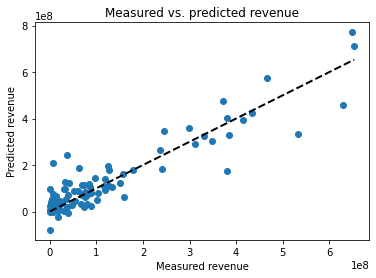

In [138]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Measured revenue')
ax.set_ylabel('Predicted revenue')
plt.title('Measured vs. predicted revenue')

plt.show()

In [135]:
importances = {}
count = 0
for feature_importance in regressor.feature_importances_:
    if feature_importance > 0.002:
        feature_name = data.columns[15:].values[count]
        importances[feature_name] = feature_importance
    count += 1

sorted_importances = sorted(importances.items(), key=operator.itemgetter(1), reverse=True)

In [136]:
sorted_importances

[('cast-stan_lee', 0.09589459),
 ('crew-brian_n._bentley', 0.0892247),
 ('cast-anthony_daniels', 0.07933011),
 ('crew-christopher_boyes', 0.050882444),
 ("crew-louis_d'esposito", 0.036540188),
 ('adventure', 0.032945186),
 ('cast-woody_harrelson', 0.027803622),
 ('crew-steven_spielberg', 0.02769665),
 ('cast-gwyneth_paltrow', 0.020696698),
 ('legendary_pictures', 0.017731844),
 ('crew-guy_williams', 0.017709084),
 ('cast-hugo_weaving', 0.016803019),
 ('lucasfilm', 0.016460106),
 ('crew-stan_lee', 0.0140809165),
 ('cast-kenny_baker', 0.013448308),
 ('action', 0.013225526),
 ('crew-denny_caira', 0.013201972),
 ('crew-luca_marco_paracels', 0.013002262),
 ('cast-scott_lawrence', 0.012992927),
 ('paramount_pictures', 0.0124849295),
 ('crew-james_cameron', 0.012292145),
 ('crew-sean_haworth', 0.011854949),
 ('crew-roland_emmerich', 0.011605685),
 ('crew-shannon_mills', 0.010684194),
 ('cast-samuel_l._jackson', 0.010057307),
 ('crew-debra_zane', 0.0100518055),
 ('crew-john_williams', 0.009069

In [140]:
data['year'].describe().T

count     431.000000
mean     2001.264501
std        12.185757
min      1927.000000
25%      1996.500000
50%      2004.000000
75%      2011.000000
max      2016.000000
Name: year, dtype: float64

# Input variables:
- budget
- list of film genres
- release date (year, day of year)
- spoken languages
- runtime
- production companies
- cast members
- crew members

# Response variables:
- revenue (main)
- vote_average (secondary)
- vote_count (secondary)